# The effectiveness of SHAP for retrieving biologically important genera

In [1]:
# Import Statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from xgboost import XGBClassifier
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, average_precision_score

cwd = Path.cwd()
print(cwd)
datasets = cwd / '../results/metagenomic_out'
results = cwd / '../results/ML_out'

/mnt/c/git_repos/pneumonia/ML_scripts


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data Preprocessing

### Load data

In [2]:
raw_df = pd.read_csv(datasets / 'RA.S.zeroed.csv')
meta = pd.read_csv(cwd / "../data/metadata/parsed_patient_metadata.csv")
# display(raw_df)
# display(meta)

merged_df = raw_df.merge(meta, on='run_id', how='left')
merged_filt = merged_df.loc[merged_df.hap_vap_cap.isin(['HAP', 'VAP']), :]

# Response
y = merged_filt.loc[:, 'hap_vap_cap'].copy()

# Features
X = merged_filt.loc[:, ~merged_filt.keys().isin(meta.keys())].copy()

# Rename features
X.columns = X.columns.str.replace('[^A-Za-z0-9]+', '_') 
print(X.shape)
print(y.shape)

# Binary encode y
y.loc[y == 'HAP'] = 1
y.loc[y == 'VAP'] = 0
y = y.astype('int')


(228, 389)
(228,)


The default value of regex will change from True to False in a future version.


In [3]:
n_splits = 10

pos = len(y[y == 1])
neg = len(y[y == 0])
split_sizes = pd.DataFrame({'HAP': [pos - int(pos / n_splits), int(pos / n_splits)], 
                           'VAP': [neg - int(neg / n_splits), int(neg / n_splits)]}, index=['Train fold', 'Test fold'])

display(split_sizes)

# Get negative to positive ratio
ratio = sum(y == 0) / sum(y == 1)

,HAP,VAP
Train fold,90,116
Test fold,10,12


In [4]:
def optimise_evaluate(X, y):
    np.random.seed(66)
    ratio = sum(y == 0) / sum(y == 1)
    
    # Hyperparemeter Optimisation using grid search (F1)
    model = XGBClassifier()
    n_estimators = range(50, 300, 10)
    max_depth = range(1, 5, 1)
    gamma = np.linspace(0.1, 3, 10)
    subsample = [0.6, 0.7, 0.8, 0.9, 1.0]
    colsample_bytree = np.linspace(0.1, 1, 10)
    
    param_grid = dict(max_depth=max_depth, 
                      n_estimators=n_estimators, 
                      colsample_bytree=colsample_bytree,
                      gamma=gamma,
                      subsample=subsample,
                      scale_pos_weight=[ratio])
    
    inner_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)
    outer_cv = StratifiedKFold(n_splits=n_splits, shuffle=True)

    # Inner CV
    model = RandomizedSearchCV(model, 
                               param_grid, 
                               scoring='f1',
                               n_iter=100,
                               n_jobs=8, 
                               cv=inner_cv, 
                               verbose=1)

    model.fit(X, y)
    best_params = model.best_params_
    print(best_params)

    # Custom metrics
    precision = make_scorer(precision_score, average='binary')
    recall = make_scorer(recall_score, average='binary')
    f1 = make_scorer(f1_score, average='binary')
    auprc = make_scorer(average_precision_score, average=None)
    
    scoring = {'precision': precision, 
               'recall': recall, 
               'AUROC': 'roc_auc',
               'F1': f1}

    # Outer CV
    outer_results = cross_validate(model, X=X, y=y, cv=outer_cv, scoring=scoring)
    outer_results = pd.DataFrame(outer_results).mean()[['test_precision', 'test_recall', 'test_F1', 'test_AUROC']]

    return outer_results, best_params


In [5]:
raw_results, raw_params = optimise_evaluate(X, y)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'subsample': 0.8, 'scale_pos_weight': 1.28, 'n_estimators': 100, 'max_depth': 4, 'gamma': 2.033333333333333, 'colsample_bytree': 0.9}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [6]:
raw_results

test_precision    0.452907
test_recall       0.510000
test_F1           0.471900
test_AUROC        0.575897
dtype: float64

In [7]:
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'criterion':['gini','entropy'],
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

from sklearn.model_selection import RandomizedSearchCV
grid_space={'max_depth':[3,5,10],
              'n_estimators':[10,50,100]
           }
rf = RandomForestClassifier()
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(rf,param_grid=grid_space,cv=5,scoring='f1')
model_grid = grid.fit(X,y)

In [8]:
cross_validate(rf, X, y, scoring='f1', cv=10, return_train_score=True)

{'fit_time': array([0.10899878, 0.1089673 , 0.1064043 , 0.10498738, 0.10468245,
        0.11527252, 0.10487795, 0.10398531, 0.10668707, 0.11579156]),
 'score_time': array([0.00780416, 0.00826979, 0.00753117, 0.00760102, 0.00751328,
        0.00752091, 0.00762534, 0.00759935, 0.00742626, 0.0076251 ]),
 'test_score': array([0.63157895, 0.66666667, 0.47058824, 0.47619048, 0.72727273,
        0.6       , 0.625     , 0.55555556, 0.66666667, 0.52631579]),
 'train_score': array([0.97297297, 0.97297297, 0.97802198, 0.98342541, 0.97802198,
        0.9726776 , 0.97826087, 0.9726776 , 0.9726776 , 0.97802198])}

In [9]:
print('Best hyperparameters are: '+str(model_grid.best_params_))
print('Best score is: '+str(model_grid.best_score_))

Best hyperparameters are: {'max_depth': 10, 'n_estimators': 10}
Best score is: 0.4963859796117861


In [12]:
# From XGboost_external_validation notebook
raw_params = {'subsample': 0.8, 'scale_pos_weight': 0.9043478260869565, 'n_estimators': 220, 'max_depth': 4, 'gamma': 0.1, 'colsample_bytree': 0.1473684210526316}
raw_model = XGBClassifier(**raw_params)
raw_model.fit(X, y)

explainer_raw = shap.TreeExplainer(raw_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_raw = explainer_raw.shap_values(X)

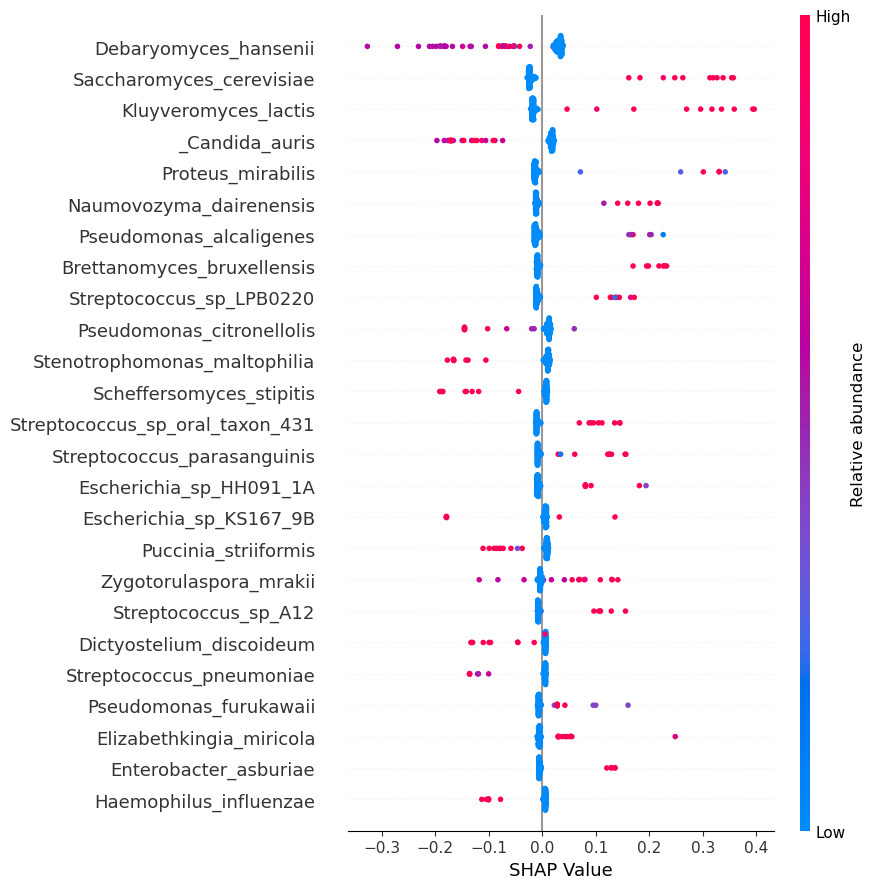

In [25]:
pre_model = XGBClassifier(**raw_params)
pre_model.fit(X=X, y=y)

pre_explainer = shap.TreeExplainer(pre_model, feature_pertubation='interventional', model_output='probability', data=X)
shap_pre = pre_explainer.shap_values(X)

shap.summary_plot(shap_pre, X, 
                  show=False, 
                  plot_size=(9, 9), 
                  color_bar_label='Relative abundance',
                  max_display=25)
fig, ax = plt.gcf(), plt.gca()
ax.set_xlabel('SHAP Value')
plt.savefig(results / 'shap_plot.png', dpi=600, format='png')

In [8]:
raw_model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.1473684210526316, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=220, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
# Convert SHAP values to dataframe
shap_df = pd.DataFrame(shap_raw, columns=X.columns)
shap_df = pd.concat([pathogen, shap_df], axis = 1)
display(shap_df)

NameError: name 'pathogen' is not defined

In [59]:
# Get only septic
shap_df = shap_df.loc[shap_df.pathogen != 'none', :]

# Loop through all confirmed and get mean absolute shap value
mean_vals = []
genus_names = []
for p in shap_df.pathogen.unique():
    values = shap_df.loc[shap_df.pathogen == p, p]
    mean_vals = mean_vals + list(values)
    genus_names = genus_names + [p] * len(values)

plot_df = pd.DataFrame({'Genus': genus_names, 'shap': mean_vals})
display(plot_df)
plot_df.to_csv(results / 'SHAP_values_per_infection.csv', index=False, header=True)

,Genus,shap
0,Escherichia,0.083723
1,Escherichia,0.115786
2,Escherichia,0.142420
3,Escherichia,0.137115
4,Escherichia,0.134323
...,...,...
112,Serratia,0.008682
113,Aerococcus,0.000000
114,Lymphocryptovirus,0.032555
115,Campylobacter,0.026858


### Force plot for septic patient (Karius-CR)

Actual Classification 1
202


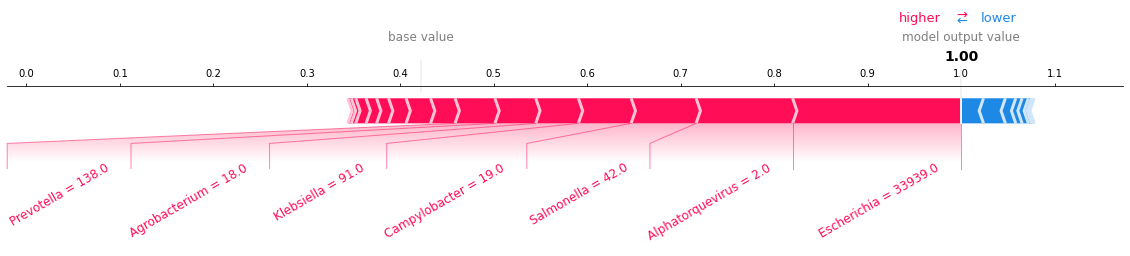

In [22]:
raw_CR = X[['Bacillus', 'Burkholderia', 'Enterococcus', 'Aeromonas', 'Cronobacter',
       'Cytomegalovirus', 'Lymphocryptovirus', 'Campylobacter', 'Pantoea',
       'Shigella', 'Klebsiella', 'Cellulomonas', 'Salmonella', 'Shewanella',
       'Megasphaera', 'Stenotrophomonas', 'Agrobacterium', 'Oerskovia',
       'Prevotella', 'Escherichia', 'Blautia', 'Bacteroides', 'Enterobacter',
       'Alphatorquevirus', 'Veillonella']].copy()

raw_CR_params = {'subsample': 0.8, 'scale_pos_weight': 1.452991452991453, 'n_estimators': 240, 'max_depth': 1, 'gamma': 1.711111111111111, 'colsample_bytree': 0.9052631578947369}
raw_CR_model = XGBClassifier(**raw_CR_params)
raw_CR_model.fit(raw_CR, y)

explainer_CR = shap.TreeExplainer(raw_CR_model, feature_pertubation='interventional', model_output='probability', data=raw_CR)
shap_CR = explainer_CR.shap_values(raw_CR)

j = 202

print(f'Actual Classification {y[j]}')
print(raw_CR.index[j])

shap.force_plot(explainer_CR.expected_value, 
                shap_CR[j,:], 
                raw_CR.iloc[j,:],
                show=False,
                matplotlib=True,
                text_rotation=30)

plt.savefig(results / 'CR_force_plot.png', dpi=600, format='png', bbox_inches='tight')
plt.show()